In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from models import *
from opt import encode
from tqdm import tnrange

sns.set_context('paper', font_scale=1.5)

Using TensorFlow backend.


TensorFlow Version: 1.9.0
Keras      Version: 2.2.0


Example Sentences

Goto(John, Doctor), Checkin(John, None), Wait(John, None), Read(John, Magazine), Treat(Doctor, John)

Goto(Bill, Dentist), Checkin(Bill, None), Wait(Bill, None), Read(Bill, Magazine), Treat(Dentist, Bill)

Goto(Natasha, Chiropractor), Checkin(Natasha, None), Wait(Natasha, None), Read(Natasha, Magazine), Treat(Chiropractor, Natasha)



BuyTicket(Sarah, Play), Goto(Sarah, Playhouse), Buy(Sarah, Food), FindSeat(Sarah, None), Watch(Sarah, Play)

BuyTicket(Jill, Movie), Goto(Jill, MovieTheater), Buy(Jill, Food),  FindSeat(Sarah, None), Watch(Jill, Movie)

BuyTicket(Nikolai, Opera), Goto(Nikolai, Operahouse), Buy(Nikolai, Drink),  FindSeat(Nikolai, None), Watch(Nikolai, Opera)

In [2]:
from opt import plate_formula, embed, encode, decode

np.random.seed(0)

# figure out how many dimensions we need using plates formula
n = 26
k = 6;      # maximum number of terms to be combined
err = 0.1; # error probability

d = plate_formula(n, k, err)
print d

def embed(d):
    return np.random.randn(1, d) / (np.sqrt(d))


a0 =[
    ['Goto', 'John', 'Doctor'],
    ['Checkin', 'John', 'None'],
    ['Read', 'John', 'Magazine'],
    ['Treat', 'Doctor', 'John']
]

a1 = [
    ['Goto', 'Bill', 'Dentist'], 
    ['Read', 'Bill', 'Magazine'],
    ['Wait', 'Bill', 'None'],
    ['Treat', 'Dentist', 'Bill']
]

a2 = [
    ['Goto', 'Natasha', 'Dentist'], 
    ['Checkin', 'Natasha', 'None'],
    ['Wait', 'Natasha', 'Magazine'],
    ['Treat', 'Chiropractor', 'Natasha']
]

b0 = [
    ['BuyTicket', 'Jill', 'Movie'],
    ['FindSeat', 'Jill', 'None'],
    ['Buy', 'Jill', 'Food'],
    ['Watch', 'Jill', 'Movie']
]

c0 = [
    ['WakeUp', 'Sarah', 'None'],
    ['GetDressed', 'Sarah', 'None'],
    ['Eat', 'Sarah', 'Toast'],
    ['Leave', 'Sarah', 'None']
    
]


# create an a version and b version of each script
scripts_1 = [a0, b0, c0]
scripts_2 = [a0, a1, b0]
scripts_3 = [a0, a1, a2]

# generate the embeddings as a function
def gen_embeddings():
    verb_property = embed(d)
    agent_property = embed(d)
    object_property = embed(d) * 0.5 + agent_property * 0.5

    words = {
        'Goto': (embed(d) + verb_property),
        'Checkin':  (embed(d) + verb_property),
        'Wait': (embed(d) + verb_property),
        'Read': (embed(d) + verb_property),
        'Treat': (embed(d) + verb_property),
        'BuyTicket': (embed(d) + verb_property),
        'FindSeat': (embed(d) + verb_property),
        'Buy': (embed(d) + verb_property),
        'Watch': (embed(d) + verb_property),
        'WakeUp': (embed(d) + verb_property),
        'GetDressed': (embed(d) + verb_property),
        'Eat': (embed(d) + verb_property),
        'Leave': (embed(d) + verb_property),
        'John':(embed(d) + agent_property),
        'Bill': (embed(d) + agent_property),
        'Natasha': (embed(d) + agent_property),
        'Magazine': (embed(d) + object_property),
        'Doctor': (embed(d) + agent_property),
        'Dentist': (embed(d) + agent_property),
        'Chiropractor': (embed(d) + agent_property),
        'Jill': (embed(d) + agent_property),
        'Movie': (embed(d) + object_property),
        'Food': (embed(d) + object_property),
        'Sarah': (embed(d) + agent_property),
        'Toast': (embed(d) + object_property),
        'None': embed(d)*2,
    }

    roles = {
        'Agent': embed(d),
        'Patient': embed(d),
        'Verb': embed(d)
    }


    def encode_sentence(s):
        return encode(words[s[0]], roles['Verb']) +\
                encode(words[s[1]], roles['Agent']) +\
                encode(words[s[2]], roles['Patient'])

    def encode_scripts(scripts):
        x_train = []
        for script in scripts:
            _x_train = []
            for s in script:
                _x_train.append(encode_sentence(s))
            x_train.append(np.concatenate(_x_train, axis=0))
        return x_train

    x_train_1 = encode_scripts(scripts_1)
    x_train_2 = encode_scripts(scripts_2)
    x_train_3 = encode_scripts(scripts_3)

    # the probe for all of these is Wait(John, None)
    # probe queues
    valid_unseen = ['Wait', 'John', 'None']
    valid_seen = ['Read', 'John', 'Magazine']
    invalid_unseen = ['GetDressed', 'John', 'None']

    x_valid = encode_sentence(valid_unseen)
    x_seen = encode_sentence(valid_seen)
    x_invalid = encode_sentence(invalid_unseen)
    
    return x_train_1, x_train_2, x_train_3, x_valid, x_seen, x_invalid

gamma=2.5
x_train_1, x_train_2, x_train_3, x_valid, x_seen, x_invalid = gen_embeddings()

print logsumexp(-np.linalg.norm(np.concatenate(x_train_1) - x_valid, axis=1) * gamma)
print logsumexp(-np.linalg.norm(np.concatenate(x_train_2) - x_valid, axis=1) * gamma)
print logsumexp(-np.linalg.norm(np.concatenate(x_train_3) - x_valid, axis=1) * gamma)

print 
print logsumexp(-np.linalg.norm(np.concatenate(x_train_1) - x_invalid, axis=1) * gamma)
print logsumexp(-np.linalg.norm(np.concatenate(x_train_2) - x_invalid, axis=1) * gamma)
print logsumexp(-np.linalg.norm(np.concatenate(x_train_3) - x_invalid, axis=1) * gamma)

print 
print logsumexp(-np.linalg.norm(np.concatenate(x_train_1) - x_seen, axis=1) * gamma)
print logsumexp(-np.linalg.norm(np.concatenate(x_train_2) - x_seen, axis=1) * gamma)
print logsumexp(-np.linalg.norm(np.concatenate(x_train_3) - x_seen, axis=1) * gamma)

185
-2.427228171947773
-2.2979647428238437
-2.2601142252897986

-2.1312322751151584
-2.5637819896747835
-2.5037303883371123

0.035695550186014606
0.07630284234588441
0.0777966825684047


## Segment and Train

In [3]:
# SEM parameters
# df0 = 1.0
# mode = 0.4
df0 = 10.
mode = 0.2
scale0 = (mode * (df0 + 2)) / df0
print scale0

lmda = 1.0  # stickyness parameter
alfa = 10.001  # concentration parameter


f_class = GRUEvent
f_opts=dict(var_scale0=scale0, var_df0=df0, dropout=0.5,
            prior_log_prob=0, t=4)#, n_hidden = int(np.floor(d/2.)))

sem_kwargs = dict(lmda=lmda, alfa=alfa, f_class=f_class, f_opts=f_opts)


0.24


In [4]:
# First, run all of the models
sem_model_1 = SEM(**sem_kwargs)
sem_model_1.run_w_boundaries(x_train_1)
print sem_model_1.results.e_hat

print sem_model_1.results.log_like

print sem_model_1.results.log_prior

Run SEM: 100%|██████████| 3/3 [00:03<00:00,  1.21s/it]

[0 0 0]
[[-109.94331543          -inf          -inf          -inf          -inf
           -inf]
 [-188.34384044 -229.07206162          -inf          -inf          -inf
           -inf]
 [  39.4112596  -144.24751754          -inf          -inf          -inf
           -inf]]
[[2.30268509       -inf       -inf       -inf       -inf       -inf]
 [1.60943791 2.30268509       -inf       -inf       -inf       -inf]
 [2.19722458 2.30268509       -inf       -inf       -inf       -inf]]


In [5]:
sem_model_2 = SEM(**sem_kwargs)
sem_model_2.run_w_boundaries(x_train_2)
print sem_model_2.results.e_hat


sem_model_2.results.log_like

Run SEM: 100%|██████████| 3/3 [00:04<00:00,  1.38s/it]

[0 0 0]


array([[-105.19235675,          -inf,          -inf,          -inf,
                 -inf,          -inf],
       [-175.57793452, -229.05359332,          -inf,          -inf,
                 -inf,          -inf],
       [ 187.83183117,  -94.24933034,          -inf,          -inf,
                 -inf,          -inf]])

In [6]:
sem_model_3 = SEM(**sem_kwargs)
sem_model_3.run_w_boundaries(x_train_3)
print sem_model_3.results.e_hat

sem_model_3.results.log_like

Run SEM: 100%|██████████| 3/3 [00:04<00:00,  1.66s/it]

[0 0 0]


array([[-105.31401442,          -inf,          -inf,          -inf,
                 -inf,          -inf],
       [-245.06219076, -258.68901622,          -inf,          -inf,
                 -inf,          -inf],
       [ 223.3236585 ,  -87.39562159,          -inf,          -inf,
                 -inf,          -inf]])

## Memory recontruction

In [7]:
# set the parameters for the Gibbs sampler
gibbs_kwargs = dict(
    memory_alpha = 10.0,
    memory_lambda = 100.0,
    memory_epsilon = np.exp(-100),
    b = 1,  # re-defined here for completeness
    tau = 0.15,  # ibid
    n_samples = 250,
    n_burnin = 100,
    leave_progress_bar=False,
)

epsilon_e = 0.75


def reconstruct_and_score(x_train, sem_model):


    # create the corrupted memory trace
    n, d = np.concatenate(x_train).shape
    y_mem = []
    for t in range(n):
        x_mem = x_train[t / 4][t % 4, :] + np.random.randn(d) * gibbs_kwargs['tau']
        e_mem = [None, sem_model.results.e_hat[t / 4]][np.random.rand() < epsilon_e]
        t_mem = t + np.random.randint(-gibbs_kwargs['b'], gibbs_kwargs['b'] + 1)
        y_mem.append([x_mem, e_mem, t_mem])

    # run the reconstruction
    # sample from memory
    gibbs_kwargs['y_mem'] = y_mem
    gibbs_kwargs['sem'] = sem_model
    y_samples, e_samples, x_samples = gibbs_memory_sampler(**gibbs_kwargs)
    
    
    
    valid_vs_invalid = []
    valid_vs_seen = []
    seen_vs_invalid = []
    for ii in range(len(x_samples)):
        x0_sample = x_samples[0]

        # evaluate Gaussian Kernel functions with gamma 
        gamma = 2.5  #prev 7.5
        valid_vs_invalid.append(
            -logsumexp(-np.linalg.norm(x_samples[ii] - x_valid, axis=1) * gamma) <
            -logsumexp(-np.linalg.norm(x_samples[ii] - x_invalid, axis=1) * gamma)
        )

        valid_vs_seen.append(
            -logsumexp(-np.linalg.norm(x_samples[ii] - x_valid, axis=1) * gamma) <
            -logsumexp(-np.linalg.norm(x_samples[ii] - x_seen, axis=1) * gamma)

        )

        seen_vs_invalid.append(
            -logsumexp(-np.linalg.norm(x_samples[ii] - x_seen, axis=1) * gamma) <
            -logsumexp(-np.linalg.norm(x_samples[ii] - x_invalid, axis=1) * gamma)

        )

    valid_vs_invalid = np.mean(valid_vs_invalid)
    valid_vs_seen = np.mean(valid_vs_seen)
    seen_vs_invalid = np.mean(seen_vs_invalid)
    accuracy = np.mean([np.mean([yi != None for yi in ys ]) for ys in y_samples])
    
    print "Valid vs Invalid {}".format(valid_vs_invalid)
    print "Valid vs Seen    {}".format(valid_vs_seen)
    print "Invalid vs Seen  {}".format(1-seen_vs_invalid)
    
    return valid_vs_invalid, valid_vs_seen, seen_vs_invalid, accuracy

In [8]:
results = []
n_batch = 25
for ii in range(n_batch):
    sem_model = SEM(**sem_kwargs)
    sem_model.run_w_boundaries(x_train_1)
    valid_vs_invalid, valid_vs_seen, seen_vs_invalid, accuracy =  reconstruct_and_score(x_train_1, sem_model)
    results.append({
        'Accuracy': accuracy,
        'Valid vs Invalid': valid_vs_invalid,
        'Valid vs Seen': valid_vs_seen,
        'Seen vs Invalid': seen_vs_invalid, 
        'Number Clusters': len(set(sem_model.results.e_hat)),
        'Script Instances': 1,
        'Batch': ii
    })

Run SEM: 100%|██████████| 3/3 [00:05<00:00,  1.69s/it]
models/memory.py:129: RuntimeWarning: divide by zero encountered in log
  log_p = p_model + np.log(p_sCRP)


Valid vs Invalid 0.268
Valid vs Seen    0.112
Invalid vs Seen  0.228


Run SEM: 100%|██████████| 3/3 [00:05<00:00,  1.85s/it]


Valid vs Invalid 0.412
Valid vs Seen    0.176
Invalid vs Seen  0.192


Run SEM: 100%|██████████| 3/3 [00:06<00:00,  2.01s/it]


Valid vs Invalid 0.316
Valid vs Seen    0.172
Invalid vs Seen  0.24


Run SEM: 100%|██████████| 3/3 [00:06<00:00,  2.13s/it]


Valid vs Invalid 0.388
Valid vs Seen    0.188
Invalid vs Seen  0.22


Run SEM: 100%|██████████| 3/3 [00:06<00:00,  2.33s/it]


Valid vs Invalid 0.412
Valid vs Seen    0.14
Invalid vs Seen  0.156


Run SEM: 100%|██████████| 3/3 [00:07<00:00,  2.50s/it]


Valid vs Invalid 0.372
Valid vs Seen    0.132
Invalid vs Seen  0.16


Run SEM: 100%|██████████| 3/3 [00:07<00:00,  2.63s/it]


Valid vs Invalid 0.276
Valid vs Seen    0.008
Invalid vs Seen  0.036


Run SEM: 100%|██████████| 3/3 [00:10<00:00,  3.41s/it]


Valid vs Invalid 0.152
Valid vs Seen    0.224
Invalid vs Seen  0.388


Run SEM: 100%|██████████| 3/3 [00:08<00:00,  2.73s/it]


Valid vs Invalid 0.224
Valid vs Seen    0.096
Invalid vs Seen  0.212


Run SEM: 100%|██████████| 3/3 [00:09<00:00,  3.18s/it]


Valid vs Invalid 0.304
Valid vs Seen    0.084
Invalid vs Seen  0.12


Run SEM: 100%|██████████| 3/3 [00:09<00:00,  3.02s/it]


Valid vs Invalid 0.312
Valid vs Seen    0.068
Invalid vs Seen  0.116


Run SEM: 100%|██████████| 3/3 [00:09<00:00,  3.18s/it]


Valid vs Invalid 0.336
Valid vs Seen    0.112
Invalid vs Seen  0.148


Run SEM: 100%|██████████| 3/3 [00:10<00:00,  3.55s/it]


Valid vs Invalid 0.348
Valid vs Seen    0.204
Invalid vs Seen  0.292


Run SEM: 100%|██████████| 3/3 [00:10<00:00,  3.51s/it]


Valid vs Invalid 0.588
Valid vs Seen    0.048
Invalid vs Seen  0.044


Run SEM: 100%|██████████| 3/3 [00:11<00:00,  3.69s/it]


Valid vs Invalid 0.568
Valid vs Seen    0.08
Invalid vs Seen  0.08


Run SEM: 100%|██████████| 3/3 [00:17<00:00,  5.69s/it]


Valid vs Invalid 0.192
Valid vs Seen    0.992
Invalid vs Seen  1.0


Run SEM: 100%|██████████| 3/3 [00:16<00:00,  5.64s/it]


Valid vs Invalid 0.652
Valid vs Seen    0.264
Invalid vs Seen  0.2


Run SEM: 100%|██████████| 3/3 [00:12<00:00,  4.22s/it]


Valid vs Invalid 0.444
Valid vs Seen    0.036
Invalid vs Seen  0.048


Run SEM: 100%|██████████| 3/3 [00:13<00:00,  4.41s/it]


Valid vs Invalid 0.504
Valid vs Seen    0.164
Invalid vs Seen  0.192


Run SEM: 100%|██████████| 3/3 [00:13<00:00,  4.51s/it]


Valid vs Invalid 0.4
Valid vs Seen    0.032
Invalid vs Seen  0.048


Run SEM: 100%|██████████| 3/3 [00:17<00:00,  5.72s/it]


Valid vs Invalid 0.256
Valid vs Seen    0.452
Invalid vs Seen  0.56


Run SEM: 100%|██████████| 3/3 [00:17<00:00,  5.79s/it]


Valid vs Invalid 0.388
Valid vs Seen    0.076
Invalid vs Seen  0.112


Run SEM: 100%|██████████| 3/3 [00:17<00:00,  5.98s/it]


Valid vs Invalid 0.584
Valid vs Seen    0.016
Invalid vs Seen  0.016


Run SEM: 100%|██████████| 3/3 [00:22<00:00,  7.58s/it]


Valid vs Invalid 0.092
Valid vs Seen    0.972
Invalid vs Seen  0.996


Run SEM: 100%|██████████| 3/3 [00:16<00:00,  5.38s/it]
                                                                

Valid vs Invalid 0.388
Valid vs Seen    0.064
Invalid vs Seen  0.084


In [9]:
for ii in range(n_batch):
    sem_model = SEM(**sem_kwargs)
    sem_model.run_w_boundaries(x_train_2)
    valid_vs_invalid, valid_vs_seen, seen_vs_invalid, accuracy  =  reconstruct_and_score(x_train_2, sem_model)
    results.append({
        'Accuracy': accuracy,
        'Valid vs Invalid': valid_vs_invalid,
        'Valid vs Seen': valid_vs_seen,
        'Seen vs Invalid': seen_vs_invalid, 
        'Number Clusters': len(set(sem_model.results.e_hat)),
        'Script Instances': 2,
        'Batch': ii
    })

Run SEM: 100%|██████████| 3/3 [00:16<00:00,  5.66s/it]


Valid vs Invalid 0.824
Valid vs Seen    0.004
Invalid vs Seen  0.004


Run SEM: 100%|██████████| 3/3 [00:17<00:00,  5.74s/it]


Valid vs Invalid 0.844
Valid vs Seen    0.008
Invalid vs Seen  0.008


Run SEM: 100%|██████████| 3/3 [00:18<00:00,  6.24s/it]


Valid vs Invalid 0.792
Valid vs Seen    0.012
Invalid vs Seen  0.004


Run SEM: 100%|██████████| 3/3 [00:17<00:00,  5.94s/it]


Valid vs Invalid 0.808
Valid vs Seen    0.012
Invalid vs Seen  0.0


Run SEM: 100%|██████████| 3/3 [00:23<00:00,  7.93s/it]


Valid vs Invalid 0.796
Valid vs Seen    0.012
Invalid vs Seen  0.004


Run SEM: 100%|██████████| 3/3 [00:18<00:00,  6.24s/it]


Valid vs Invalid 0.904
Valid vs Seen    0.028
Invalid vs Seen  0.004


Run SEM: 100%|██████████| 3/3 [00:19<00:00,  6.52s/it]


Valid vs Invalid 0.752
Valid vs Seen    0.02
Invalid vs Seen  0.004


Run SEM: 100%|██████████| 3/3 [00:19<00:00,  6.51s/it]


Valid vs Invalid 0.836
Valid vs Seen    0.012
Invalid vs Seen  0.004


Run SEM: 100%|██████████| 3/3 [00:19<00:00,  6.58s/it]


Valid vs Invalid 0.784
Valid vs Seen    0.004
Invalid vs Seen  0.0


Run SEM: 100%|██████████| 3/3 [00:20<00:00,  6.99s/it]


Valid vs Invalid 0.836
Valid vs Seen    0.02
Invalid vs Seen  0.008


Run SEM: 100%|██████████| 3/3 [00:22<00:00,  7.41s/it]


Valid vs Invalid 0.808
Valid vs Seen    0.008
Invalid vs Seen  0.004


Run SEM: 100%|██████████| 3/3 [00:22<00:00,  7.50s/it]


Valid vs Invalid 0.76
Valid vs Seen    0.004
Invalid vs Seen  0.0


Run SEM: 100%|██████████| 3/3 [00:30<00:00, 10.32s/it]


Valid vs Invalid 0.904
Valid vs Seen    0.032
Invalid vs Seen  0.008


Run SEM: 100%|██████████| 3/3 [00:23<00:00,  7.82s/it]


Valid vs Invalid 0.768
Valid vs Seen    0.02
Invalid vs Seen  0.008


Run SEM: 100%|██████████| 3/3 [00:24<00:00,  8.13s/it]


Valid vs Invalid 0.844
Valid vs Seen    0.0
Invalid vs Seen  0.0


Run SEM: 100%|██████████| 3/3 [00:24<00:00,  8.27s/it]


Valid vs Invalid 0.82
Valid vs Seen    0.02
Invalid vs Seen  0.004


Run SEM: 100%|██████████| 3/3 [00:25<00:00,  8.39s/it]


Valid vs Invalid 0.924
Valid vs Seen    0.032
Invalid vs Seen  0.004


Run SEM: 100%|██████████| 3/3 [00:25<00:00,  8.52s/it]


Valid vs Invalid 0.74
Valid vs Seen    0.012
Invalid vs Seen  0.004


Run SEM: 100%|██████████| 3/3 [00:38<00:00, 12.90s/it]


Valid vs Invalid 0.592
Valid vs Seen    0.08
Invalid vs Seen  0.048


Run SEM: 100%|██████████| 3/3 [00:26<00:00,  8.93s/it]


Valid vs Invalid 0.872
Valid vs Seen    0.032
Invalid vs Seen  0.008


Run SEM: 100%|██████████| 3/3 [00:25<00:00,  8.59s/it]


Valid vs Invalid 0.644
Valid vs Seen    0.012
Invalid vs Seen  0.0


Run SEM: 100%|██████████| 3/3 [00:26<00:00,  8.97s/it]


Valid vs Invalid 0.844
Valid vs Seen    0.004
Invalid vs Seen  0.0


Run SEM: 100%|██████████| 3/3 [00:39<00:00, 13.09s/it]


Valid vs Invalid 0.808
Valid vs Seen    0.028
Invalid vs Seen  0.016


Run SEM: 100%|██████████| 3/3 [00:28<00:00,  9.61s/it]


Valid vs Invalid 0.82
Valid vs Seen    0.012
Invalid vs Seen  0.02


Run SEM: 100%|██████████| 3/3 [00:28<00:00,  9.60s/it]
                                                                

Valid vs Invalid 0.852
Valid vs Seen    0.016
Invalid vs Seen  0.008


In [10]:
for ii in range(n_batch):
    sem_model = SEM(**sem_kwargs)
    sem_model.run_w_boundaries(x_train_3)
    valid_vs_invalid, valid_vs_seen, seen_vs_invalid, accuracy =  reconstruct_and_score(x_train_3, sem_model)
    results.append({
        'Accuracy': accuracy,
        'Valid vs Invalid': valid_vs_invalid,
        'Valid vs Seen': valid_vs_seen,
        'Seen vs Invalid': seen_vs_invalid, 
        'Number Clusters': len(set(sem_model.results.e_hat)),
        'Script Instances': 3,
        'Batch': ii
    })

Run SEM: 100%|██████████| 3/3 [00:44<00:00, 15.00s/it]


Valid vs Invalid 0.992
Valid vs Seen    0.032
Invalid vs Seen  0.0


Run SEM: 100%|██████████| 3/3 [00:30<00:00, 10.16s/it]


Valid vs Invalid 0.952
Valid vs Seen    0.044
Invalid vs Seen  0.008


Run SEM: 100%|██████████| 3/3 [00:31<00:00, 10.45s/it]


Valid vs Invalid 0.96
Valid vs Seen    0.016
Invalid vs Seen  0.004


Run SEM: 100%|██████████| 3/3 [00:32<00:00, 10.70s/it]


Valid vs Invalid 0.932
Valid vs Seen    0.044
Invalid vs Seen  0.016


Run SEM: 100%|██████████| 3/3 [00:32<00:00, 10.81s/it]


Valid vs Invalid 0.908
Valid vs Seen    0.04
Invalid vs Seen  0.0


Run SEM: 100%|██████████| 3/3 [00:31<00:00, 10.65s/it]


Valid vs Invalid 0.856
Valid vs Seen    0.036
Invalid vs Seen  0.012


Run SEM: 100%|██████████| 3/3 [00:34<00:00, 11.61s/it]


Valid vs Invalid 0.884
Valid vs Seen    0.016
Invalid vs Seen  0.004


Run SEM: 100%|██████████| 3/3 [00:33<00:00, 11.08s/it]


Valid vs Invalid 0.796
Valid vs Seen    0.004
Invalid vs Seen  0.004


Run SEM: 100%|██████████| 3/3 [00:33<00:00, 11.20s/it]


Valid vs Invalid 0.956
Valid vs Seen    0.012
Invalid vs Seen  0.004


Run SEM: 100%|██████████| 3/3 [00:35<00:00, 11.69s/it]


Valid vs Invalid 0.984
Valid vs Seen    0.04
Invalid vs Seen  0.004


Run SEM: 100%|██████████| 3/3 [01:00<00:00, 20.31s/it]


Valid vs Invalid 0.944
Valid vs Seen    0.056
Invalid vs Seen  0.008


Run SEM: 100%|██████████| 3/3 [00:33<00:00, 11.04s/it]


Valid vs Invalid 0.908
Valid vs Seen    0.008
Invalid vs Seen  0.004


Run SEM: 100%|██████████| 3/3 [00:34<00:00, 11.46s/it]


Valid vs Invalid 0.992
Valid vs Seen    0.012
Invalid vs Seen  0.0


Run SEM: 100%|██████████| 3/3 [00:36<00:00, 12.29s/it]


Valid vs Invalid 0.872
Valid vs Seen    0.008
Invalid vs Seen  0.0


Run SEM: 100%|██████████| 3/3 [00:36<00:00, 12.31s/it]


Valid vs Invalid 0.88
Valid vs Seen    0.0
Invalid vs Seen  0.0


Run SEM: 100%|██████████| 3/3 [00:37<00:00, 12.52s/it]


Valid vs Invalid 0.972
Valid vs Seen    0.0
Invalid vs Seen  0.0


Run SEM: 100%|██████████| 3/3 [00:39<00:00, 13.24s/it]


Valid vs Invalid 0.944
Valid vs Seen    0.008
Invalid vs Seen  0.004


Run SEM: 100%|██████████| 3/3 [01:01<00:00, 20.63s/it]


Valid vs Invalid 0.972
Valid vs Seen    0.008
Invalid vs Seen  0.0


Run SEM: 100%|██████████| 3/3 [00:40<00:00, 13.58s/it]


Valid vs Invalid 0.988
Valid vs Seen    0.032
Invalid vs Seen  0.0


Run SEM: 100%|██████████| 3/3 [00:44<00:00, 14.91s/it]


Valid vs Invalid 0.936
Valid vs Seen    0.0
Invalid vs Seen  0.008


Run SEM: 100%|██████████| 3/3 [00:40<00:00, 13.50s/it]


Valid vs Invalid 0.976
Valid vs Seen    0.008
Invalid vs Seen  0.0


Run SEM: 100%|██████████| 3/3 [00:42<00:00, 14.19s/it]


Valid vs Invalid 0.984
Valid vs Seen    0.004
Invalid vs Seen  0.0


Run SEM: 100%|██████████| 3/3 [00:43<00:00, 14.35s/it]


Valid vs Invalid 0.868
Valid vs Seen    0.016
Invalid vs Seen  0.008


Run SEM: 100%|██████████| 3/3 [00:42<00:00, 14.11s/it]


Valid vs Invalid 0.952
Valid vs Seen    0.056
Invalid vs Seen  0.02


Run SEM: 100%|██████████| 3/3 [00:42<00:00, 14.23s/it]


Valid vs Invalid 0.976
Valid vs Seen    0.048
Invalid vs Seen  0.004


In [11]:
results = pd.DataFrame(results)

In [12]:
y = results.groupby('Script Instances').mean()['Valid vs Seen']
y_err = results.groupby('Script Instances').std()['Valid vs Seen'] / np.sqrt(8)

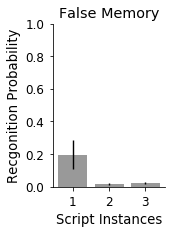

In [13]:
plt.figure(figsize=(2, 3))
plt.bar(range(3), y, facecolor='k', alpha=0.4)
plt.errorbar(range(3), y, y_err, ls=' ', c='k')
plt.xlabel('Script Instances')
plt.xticks(range(0, 3), [1, 2, 3])
plt.ylabel('Recgonition Probability')
plt.ylim([0, 1])
plt.title('False Memory')
sns.despine()

In [14]:
results.groupby('Script Instances').mean()

,Accuracy,Batch,Number Clusters,Seen vs Invalid,Valid vs Invalid,Valid vs Seen
Script Instances,,,,,,
1,0.837947,12.0,1.24,0.76448,0.36704,0.19648
2,0.865120,12.0,1.04,0.99312,0.80704,0.01776
3,0.898507,12.0,1.04,0.99552,0.93536,0.02192


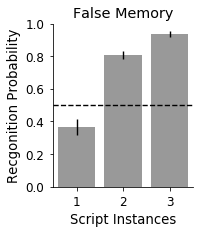

In [15]:
y = results.groupby('Script Instances').mean()['Valid vs Invalid']
y_err = results.groupby('Script Instances').std()['Valid vs Invalid'] / np.sqrt(8)

plt.figure(figsize=(2.5, 3))
plt.bar(range(3), y, facecolor='k', alpha=0.4)
plt.errorbar(range(3), y, y_err, ls=' ', c='k')
plt.xlabel('Script Instances')
plt.xticks(range(0, 3), [1, 2, 3])
plt.ylabel('Recgonition Probability')
plt.ylim([0, 1])
plt.title('False Memory')
plt.plot([-0.5, 2.5], [0.5, 0.5], ls='--', c='k')
plt.xlim([-0.5, 2.5])
sns.despine()
plt.savefig('bower_new.png', bbox_inches='tight')